In [ ]:
%%capture
!pip install transformers
!pip install torchaudio
!pip install -U datasets
!pip install fsspec==2023.9.2
!pip install pydub webrtcvad

In [ ]:
import math, torch, random, numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2FeatureExtractor, WavLMModel
from datasets import load_dataset, concatenate_datasets

# emotion → ID
EMO2ID = {"neu":0, "hap":1, "sad":2, "ang":3}

# feature extractor & model
FE = Wav2Vec2FeatureExtractor.from_pretrained(
    "microsoft/wavlm-large", sampling_rate=16000
)
ENC = WavLMModel.from_pretrained("microsoft/wavlm-large")

# freeze CNN feature‐extractor
for p in ENC.feature_extractor.parameters():
    p.requires_grad = False


dataset = load_dataset("Zahra99/IEMOCAP_Audio")

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/915 [00:00<?, ?B/s]

(…)-00000-of-00001-04e11ca668d90573.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

(…)-00000-of-00001-f6132100b374cb18.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)-00000-of-00001-6e102fcb5c1126b4.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

(…)-00000-of-00001-e39531a7c694b50d.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

(…)-00000-of-00001-03769060403172ce.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

Generating session1 split:   0%|          | 0/1085 [00:00<?, ? examples/s]

Generating session2 split:   0%|          | 0/1023 [00:00<?, ? examples/s]

Generating session3 split:   0%|          | 0/1151 [00:00<?, ? examples/s]

Generating session4 split:   0%|          | 0/1031 [00:00<?, ? examples/s]

Generating session5 split:   0%|          | 0/1241 [00:00<?, ? examples/s]

In [ ]:
import random
import numpy as np
import webrtcvad
from pydub import AudioSegment
from datasets import Dataset
from collections import deque

FRAME_DURATION_MS = 30
PADDING_DURATION_MS = 30
AGGRESSIVENESS = 2

class Frame:
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset+n], timestamp, duration)
        timestamp += duration
        offset += n

def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, s in ring_buffer if s])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                for f, _ in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, s in ring_buffer if not s])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield b"".join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if voiced_frames:
        yield b"".join([f.bytes for f in voiced_frames])

def apply_vad(array, sr):
    pcm16 = (array * 32767).astype(np.int16).tobytes()
    vad = webrtcvad.Vad(AGGRESSIVENESS)
    frames = list(frame_generator(FRAME_DURATION_MS, pcm16, sr))
    segments = vad_collector(sr, FRAME_DURATION_MS, PADDING_DURATION_MS, vad, frames)
    voiced = b"".join(segments)
    return np.frombuffer(voiced, np.int16).astype(np.float32) / 32767.0

combinations = ["neu_emo","emo_neu","neu_emo_neu","emo_emo"]
probabilities = np.array([0.25,0.25,0.25,0.25])

def prepare_sed_dataset(utterance_ds, label_map, speaker_field=None, seed=123):
    random.seed(seed)
    processed = []
    for ex in utterance_ds:
        emo = label_map.get(ex["label"])
        if emo is None:
            continue
        spk = ex[speaker_field] if speaker_field and speaker_field in ex else "all"
        arr, sr = ex["audio"]["array"], ex["audio"]["sampling_rate"]
        arr = apply_vad(arr, sr)
        ints = (arr * 32767).astype(np.int16)
        seg = AudioSegment(ints.tobytes(), sample_width=2, frame_rate=sr, channels=1)
        processed.append({"seg": seg, "emotion": emo, "speaker": spk})

    groups = {}
    for item in processed:
        groups.setdefault(item["speaker"], []).append(item)

    records = []
    for spk, items in groups.items():
        emo_items = [i for i in items if i["emotion"]!="neu"]
        neu_items = [i for i in items if i["emotion"]=="neu"] * 10
        random.shuffle(emo_items)
        random.shuffle(neu_items)
        idx = 0
        while emo_items:
            combo = random.choices(combinations, probabilities)[0]
            if combo=="neu_emo":
                n = neu_items.pop(0); e = emo_items.pop(0)
                e_seg = e["seg"].apply_gain(n["seg"].dBFS - e["seg"].dBFS)
                comb = n["seg"] + e_seg
                events = [{"emo": e["emotion"], "start": n["seg"].duration_seconds, "end": comb.duration_seconds}]
            elif combo=="emo_neu":
                e = emo_items.pop(0); n = neu_items.pop(0)
                n_seg = n["seg"].apply_gain(e["seg"].dBFS - n["seg"].dBFS)
                comb = e["seg"] + n_seg
                events = [{"emo": e["emotion"], "start": 0, "end": e["seg"].duration_seconds}]
            elif combo=="neu_emo_neu":
                n1 = neu_items.pop(0); e = emo_items.pop(0); n2 = neu_items.pop(0)
                e_seg = e["seg"].apply_gain(n1["seg"].dBFS - e["seg"].dBFS)
                n2_seg = n2["seg"].apply_gain(n1["seg"].dBFS - n2["seg"].dBFS)
                comb = n1["seg"] + e_seg + n2_seg
                start = n1["seg"].duration_seconds
                events = [{"emo": e["emotion"], "start": start, "end": start + e_seg.duration_seconds}]
            else:
                e = emo_items.pop(0)
                comb = e["seg"]
                events = [{"emo": e["emotion"], "start": 0, "end": comb.duration_seconds}]

            samples = np.array(comb.get_array_of_samples(), dtype=np.int16)
            array = samples.astype(np.float32) / 32767.0
            records.append({
                "id":        f"{spk}_{idx}",
                "audio":     {"array": array, "sampling_rate": comb.frame_rate},
                "duration":  comb.duration_seconds,
                "emotion":   events
            })
            idx += 1

    return Dataset.from_list(records)

In [ ]:
from datasets import concatenate_datasets
CLASS_NAMES = ['ang', 'hap', 'neu', 'sad']
LABEL_MAP = dict(zip(CLASS_NAMES, range(len(CLASS_NAMES))))
id2label = {0: 'ang', 1: 'hap', 2: 'neu', 3: 'sad'}
sed_ds = prepare_sed_dataset(concatenate_datasets([dataset[f'session{i}'] for i in range(1,6)]), id2label, speaker_field=None, seed=42)
sed_ds

Dataset({
    features: ['id', 'audio', 'duration', 'emotion'],
    num_rows: 3823
})

In [ ]:
from pprint import pprint
pprint(sed_ds[0]['emotion'])

[{'emo': 'ang', 'end': 3.42, 'start': 0.0}]


In [ ]:
device = None

In [ ]:
FRAME_SHIFT = 0.02
EMO2ID = LABEL_MAP
IGNORE_INDEX = -100
RF = 400 # total receptive‐field in samples based on CNN FE configuration [(10,5),(3,2),(3,2),(3,2),(3,2),(2,2),(2,2)]
S = 320 # total hop-size in samples

def get_overlap(a,b):
    return max(0, min(a[1],b[1]) - max(a[0],b[0]))

def preprocess(example):
    if len(example["audio"]["array"]) == 0:
        return None
    enc = FE(
        example["audio"]["array"],
        sampling_rate=example["audio"]["sampling_rate"],
        return_tensors="pt",
        padding=False
    )
    iv = enc.input_values[0]
    am = enc.attention_mask[0]
    if device:
        iv = iv.to(device)
        am = am.to(device)

    L = len(example["audio"]["array"]) # size of audio
    sr = example["audio"]["sampling_rate"] # sampling rate
    n_frames = 1 if L < RF else math.floor((L - RF) / S) + 1
    labels = []
    for i in range(n_frames):
        start = (i * S) / sr
        end = (i * S + RF) / sr
        emo = None
        for seg in example["emotion"]:
            if get_overlap((start, end),(seg["start"],seg["end"])) >= 0.5*(end-start):
                emo = EMO2ID[seg["emo"]]
                break
        if emo is None:
            emo = EMO2ID["neu"]
        labels.append(emo)
    return {"input_values": iv, "attention_mask": am, "labels": torch.tensor(labels)}

sed_ds = sed_ds.map(preprocess, remove_columns=["audio","duration"])
sed_ds = sed_ds.filter(lambda x: x is not None) # Filter out None values
sed_ds.set_format(type="torch", columns=["input_values","attention_mask","labels"])
sed_ds

Map:   0%|          | 0/3823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3821 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'emotion', 'input_values', 'attention_mask', 'labels'],
    num_rows: 3821
})

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    ivs = pad_sequence([x["input_values"]   for x in batch],
                       batch_first=True,
                       padding_value=IGNORE_INDEX)
    ams = pad_sequence([x["attention_mask"] for x in batch],
                       batch_first=True,
                       padding_value=0).long()
    lbs = pad_sequence([x["labels"]         for x in batch],
                       batch_first=True,
                       padding_value=IGNORE_INDEX).long()
    return {"input_values": ivs, "attention_mask": ams, "labels": lbs}


In [ ]:
class EmotionDiarizationModel(nn.Module):
    def __init__(self, encoder, num_labels=4):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)
    def forward(self, input_values, attention_mask=None):
        hs = self.encoder(input_values, attention_mask=attention_mask).last_hidden_state
        return self.classifier(hs)

In [ ]:
device = if torch.cuda.is_available() else "cpu"
ENC.to(device)
model = EmotionDiarizationModel(ENC).to(device)

optimizer = torch.optim.Adam([
    {"params": model.encoder.encoder.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(),       "lr": 1e-4},
])
criterion = nn.CrossEntropyLoss()

loader = DataLoader(sed_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm

def train_one_epoch():
    model.train()
    total = 0
    for batch in tqdm(loader):
        iv = batch["input_values"].to(device)
        am = batch["attention_mask"].to(device)
        lb = batch["labels"].to(device)
        logits = model(iv, am)
        B, T, C = logits.shape
        loss = criterion(logits.view(B*T, C), lb.view(B*T))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total/len(loader)

for i in range(10):
    print(f"\nepoch {i} loss: {train_one_epoch():.4f}")


  0%|          | 0/1911 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 1911/1911 [05:29<00:00,  5.79it/s]



epoch 0 loss: 1.0228


100%|██████████| 1911/1911 [05:27<00:00,  5.83it/s]



epoch 1 loss: 0.7278


100%|██████████| 1911/1911 [05:26<00:00,  5.85it/s]



epoch 2 loss: 0.5900


100%|██████████| 1911/1911 [05:26<00:00,  5.84it/s]



epoch 3 loss: 0.4958


100%|██████████| 1911/1911 [05:27<00:00,  5.83it/s]



epoch 4 loss: 0.4338


100%|██████████| 1911/1911 [05:27<00:00,  5.83it/s]



epoch 5 loss: 0.3768


100%|██████████| 1911/1911 [05:26<00:00,  5.84it/s]



epoch 6 loss: 0.3237


100%|██████████| 1911/1911 [05:26<00:00,  5.86it/s]



epoch 7 loss: 0.2652


100%|██████████| 1911/1911 [05:27<00:00,  5.84it/s]



epoch 8 loss: 0.2359


100%|██████████| 1911/1911 [05:26<00:00,  5.85it/s]


epoch 9 loss: 0.2202


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# @title EDER speechbrain implementation

"""Calculates Emotion Diarization Error Rate (EDER) which is the sum of Missed Emotion (ME),
False Alarm (FA), and Confusion (CF).

Authors
 * Yingzhi Wang 2023
"""


def EDER(prediction, id, duration, emotion, window_length, stride):
    """Calculates the EDER value

    Arguments
    ---------
    prediction: list
        a list of frame-wise predictions of the utterance
    id: str
        id of the utterance
    duration: float
        duration of the utterance
    emotion: list of dicts
        the ground truth emotion and its duration,
        e.g. [{'emo': 'angry', 'start': 1.016, 'end': 6.336}]
    window_length: float
        the frame length used for frame-wise prediction
    stride: float
        the frame length used for frame-wise prediction

    Returns
    -------
    float: the calculated EDER for the utterance

    Example
    -------
    >>> from speechbrain.utils.EDER import EDER
    >>> prediction=['n', 'n', 'n', 'a', 'a', 'a']
    >>> id="spk1_1"
    >>> duration=1.22
    >>> emotion=[{'emo': 'angry', 'start': 0.39, 'end': 1.10}]
    >>> window_length = 0.2
    >>> stride = 0.2
    >>> EDER(prediction, id, duration, emotion, window_length, stride)
    0.2704918032786885
    """
    duration = float(duration)  # for recipe tests
    lol = []
    for i in range(len(prediction)):
        start = stride * i
        end = start + window_length
        lol.append([id, start, end, prediction[i]])

    lol = merge_ssegs_same_emotion_adjacent(lol)
    if len(lol) != 1:
        lol = distribute_overlap(lol)

    ref = reference_to_lol(id, duration, emotion)

    good_preds = 0
    for i in ref:
        candidates = [element for element in lol if element[3] == i[3]]
        ref_interval = [i[1], i[2]]

        for candidate in candidates:
            overlap = getOverlap(ref_interval, [candidate[1], candidate[2]])
            good_preds += overlap
    return 1 - good_preds / duration


def getOverlap(a, b):
    """Get the overlapped length of two intervals

    Arguments
    ---------
    a : list
    b : list

    Returns
    -------
    float: overlapped length

    Example
    -------
    >>> from speechbrain.utils.EDER import getOverlap
    >>> interval1=[1.2, 3.4]
    >>> interval2=[2.3, 4.5]
    >>> getOverlap(interval1, interval2)
    1.1
    """
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))


def is_overlapped(end1, start2):
    """Returns True if segments are overlapping.

    Arguments
    ---------
    end1 : float
        End time of the first segment.
    start2 : float
        Start time of the second segment.

    Returns
    -------
    overlapped : bool
        True of segments overlapped else False.

    Example
    -------
    >>> is_overlapped(5.5, 3.4)
    True
    >>> is_overlapped(5.5, 6.4)
    False
    """
    return start2 <= end1


def merge_ssegs_same_emotion_adjacent(lol):
    """Merge adjacent sub-segs if they are the same emotion.

    Arguments
    ---------
    lol : list of list
        Each list contains [utt_id, sseg_start, sseg_end, emo_label].

    Returns
    -------
    new_lol : list of list
        new_lol contains adjacent segments merged from the same emotion ID.
    Example
    -------
    >>> from speechbrain.utils.EDER import merge_ssegs_same_emotion_adjacent
    >>> lol=[['u1', 0.0, 7.0, 'a'],
    ... ['u1', 7.0, 9.0, 'a'],
    ... ['u1', 9.0, 11.0, 'n'],
    ... ['u1', 11.0, 13.0, 'n'],
    ... ['u1', 13.0, 15.0, 'n'],
    ... ['u1', 15.0, 16.0, 'a']]
    >>> merge_ssegs_same_emotion_adjacent(lol)
    [['u1', 0.0, 9.0, 'a'], ['u1', 9.0, 15.0, 'n'], ['u1', 15.0, 16.0, 'a']]
    """
    new_lol = []

    # Start from the first sub-seg
    sseg = lol[0]
    flag = False
    for i in range(1, len(lol)):
        next_sseg = lol[i]
        # IF sub-segments overlap AND has same emotion THEN merge
        if is_overlapped(sseg[2], next_sseg[1]) and sseg[3] == next_sseg[3]:
            sseg[2] = next_sseg[2]  # just update the end time
            # This is important. For the last sseg, if it is the same emotion then merge
            # Make sure we don't append the last segment once more. Hence, set FLAG=True
            if i == len(lol) - 1:
                flag = True
                new_lol.append(sseg)
        else:
            new_lol.append(sseg)
            sseg = next_sseg
    # Add last segment only when it was skipped earlier.
    if flag is False:
        new_lol.append(lol[-1])

    return new_lol


def reference_to_lol(id, duration, emotion):
    """Change reference to a list of list

    Arguments
    ---------
    id: str
        id of the utterance
    duration: float
        duration of the utterance
    emotion: list of dicts
        the ground truth emotion and its duration,
        e.g. [{'emo': 'angry', 'start': 1.016, 'end': 6.336}]

    Returns
    -------
    lol : list of list
        It has each list structure as [rec_id, sseg_start, sseg_end, spkr_id].

    Example
    -------
    >>> from speechbrain.utils.EDER import reference_to_lol
    >>> id="u1"
    >>> duration=8.0
    >>> emotion=[{'emo': 'angry', 'start': 1.016, 'end': 6.336}]
    >>> reference_to_lol(id, duration, emotion)
    [['u1', 0, 1.016, 'n'], ['u1', 1.016, 6.336, 'a'], ['u1', 6.336, 8.0, 'n']]
    """
    assert (
        len(emotion) == 1
    ), "NotImplementedError: The solution is only implemented for one-emotion utterance for now."
    lol = []

    start = emotion[0]["start"]
    end = emotion[0]["end"]
    if start > 0:
        lol.append([id, 0, start, "n"])
    lol.append([id, start, end, emotion[0]["emo"][0]])

    duration = float(duration)  # for recipe tests
    if end < duration:
        lol.append([id, end, duration, "n"])
    return lol


def distribute_overlap(lol):
    """Distributes the overlapped speech equally among the adjacent segments
    with different emotions.

    Arguments
    ---------
    lol : list of list
        It has each list structure as [rec_id, sseg_start, sseg_end, spkr_id].

    Returns
    -------
    new_lol : list of list
        It contains the overlapped part equally divided among the adjacent
        segments with different emotion IDs.

    Example
    -------
    >>> lol = [
    ...     ['r1', 5.5, 9.0, 's1'],
    ...     ['r1', 8.0, 11.0, 's2'],
    ...     ['r1', 11.5, 13.0, 's2'],
    ...     ['r1', 12.0, 15.0, 's1'],
    ... ]
    >>> distribute_overlap(lol)
    [['r1', 5.5, 8.5, 's1'], ['r1', 8.5, 11.0, 's2'], ['r1', 11.5, 12.5, 's2'], ['r1', 12.5, 15.0, 's1']]
    """
    new_lol = []
    sseg = lol[0]

    # Add first sub-segment here to avoid error at: "if new_lol[-1] != sseg:" when new_lol is empty
    # new_lol.append(sseg)

    for i in range(1, len(lol)):
        next_sseg = lol[i]
        # No need to check if they are different emotions.
        # Because if segments are overlapped then they always have different emotions.
        # This is because similar emotion's adjacent sub-segments are already merged by "merge_ssegs_same_emotion()"

        if is_overlapped(sseg[2], next_sseg[1]):

            # Get overlap duration.
            # Now this overlap will be divided equally between adjacent segments.
            overlap = sseg[2] - next_sseg[1]

            # Update end time of old seg
            sseg[2] = sseg[2] - (overlap / 2.0)

            # Update start time of next seg
            next_sseg[1] = next_sseg[1] + (overlap / 2.0)

            if len(new_lol) == 0:
                # For first sub-segment entry
                new_lol.append(sseg)
            else:
                # To avoid duplicate entries
                if new_lol[-1] != sseg:
                    new_lol.append(sseg)

            # Current sub-segment is next sub-segment
            sseg = next_sseg

        else:
            # For the first sseg
            if len(new_lol) == 0:
                new_lol.append(sseg)
            else:
                # To avoid duplicate entries
                if new_lol[-1] != sseg:
                    new_lol.append(sseg)

            # Update the current sub-segment
            sseg = next_sseg

    # Add the remaining last sub-segment
    new_lol.append(next_sseg)

    return new_lol

In [ ]:
samples = load_dataset('mangoesai/ZED4', split='train')
samples

README.md:   0%|          | 0.00/700 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/31.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/180 [00:00<?, ? examples/s]

Dataset({
    features: ['file_name', 'wav', 'transcription', 'emotion', 'duration', 'emotion_start', 'emotion_end', 'speaker_id'],
    num_rows: 180
})

In [ ]:
from uuid import uuid4
emo_adapt = {2:0, 1:3,0:1}
def parse_to_sed_format(sample):
    sample['emotion'] = [{
        'emo': id2label[emo_adapt[sample['emotion']]],
        'start': sample['emotion_start'],
        'end': sample['emotion_end']
    }]
    sample['id'] = str(uuid4())
    sample['audio'] = sample['wav']
    return sample

eval_ds = samples.map(parse_to_sed_format, remove_columns=['emotion_start','emotion_end', 'speaker_id', 'transcription', 'file_name', 'wav'])
eval_ds

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Dataset({
    features: ['emotion', 'duration', 'id', 'audio'],
    num_rows: 180
})

In [ ]:
def reconstruct_segments(preds, frame_shift=FRAME_SHIFT, min_duration=0.5):
    id2emo = {v: k for k, v in EMO2ID.items()}
    segs = []
    cur = preds[0].item()
    start = 0
    for i, p in enumerate(preds[1:], 1):
        if p.item() != cur:
            segs.append({
                "emo":  id2emo[cur],
                "start": start * frame_shift,
                "end":   i * frame_shift
            })
            start, cur = i, p.item()
    segs.append({
        "emo":  id2emo[cur],
        "start": start * frame_shift,
        "end":   len(preds) * frame_shift
    })
    if len(segs) <= 1:
        return segs
    merged = []
    for i, seg in enumerate(segs):
        length = seg["end"] - seg["start"]
        if length < min_duration:
            if merged:
                merged[-1]["end"] = seg["end"]
            else:
                segs[i+1]["start"] = seg["start"]
            continue
        merged.append(seg)
    return merged


In [ ]:

def collate_eval(batch):
    ivs = torch.nn.utils.rnn.pad_sequence(
        [x["input_values"]   for x in batch], batch_first=True
    )
    ams = torch.nn.utils.rnn.pad_sequence(
        [x["attention_mask"] for x in batch], batch_first=True
    ).long()
    lbs = torch.nn.utils.rnn.pad_sequence(
        [x["labels"]         for x in batch], batch_first=True, padding_value=IGNORE_INDEX
    ).long()
    ids       = [x["id"]       for x in batch]
    durations = [x["duration"] for x in batch]
    events    = [x["emotion"]  for x in batch]
    return {
        "input_values": ivs,
        "attention_mask": ams,
        "labels": lbs,
        "id": ids,
        "duration": durations,
        "emotion": events,
    }


eval_ds = eval_ds.map(preprocess, remove_columns=["audio"])
eval_ds.set_format(type="torch", columns=["input_values","attention_mask","labels","emotion", "id","duration"])
eval_loader = torch.utils.data.DataLoader(
    eval_ds,
    batch_size=2,
    collate_fn=collate_eval,
    shuffle=False,
)
eval_ds

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Dataset({
    features: ['emotion', 'duration', 'id', 'input_values', 'attention_mask', 'labels'],
    num_rows: 180
})

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    eders = []
    total_corr = 0
    total_frames = 0
    with torch.no_grad():
        for batch in loader:
            iv = batch["input_values"].to(device)
            am = batch["attention_mask"].to(device)
            lb = batch["labels"].to(device)
            logits = model(iv, attention_mask=am)
            preds = torch.argmax(logits, dim=-1)
            mask = lb != IGNORE_INDEX
            total_corr += (preds[mask] == lb[mask]).sum().item()
            total_frames += mask.sum().item()
            for i in range(len(batch["id"])):
                pred_seq = preds[i]
                segs = reconstruct_segments(pred_seq)
                eder = EDER(
                    prediction=segs,
                    id=batch["id"][i],
                    duration=batch["duration"][i],
                    emotion=batch["emotion"][i],
                    window_length=0.25,
                    stride=0.2,
                )
                eders.append(eder)
    frame_acc = total_corr / total_frames
    avg_eder = sum(eders) / len(eders)
    print(f"Frame Acc: {frame_acc:.4f}    EDER: {avg_eder:.4f}")

evaluate(model, eval_loader, device)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Frame Acc: 0.6302    EDER: 1.0000


In [ ]:
import matplotlib.pyplot as plt

EMO_COLORS = {
    "neu": "tab:blue",
    "hap":   "tab:orange",
    "sad":     "tab:green",
    "ang":   "tab:red",
}

def visualize_segments(duration, pred_segments, gold_segments):
    fig, ax = plt.subplots(figsize=(10, 3))

    for seg in gold_segments:
        color = EMO_COLORS.get(seg["emo"], "lightgray")
        ax.barh(
            1,
            seg["end"] - seg["start"],
            left=seg["start"],
            height=0.4,
            color=color,
            alpha=0.6,
        )

    for seg in pred_segments:
        color = EMO_COLORS.get(seg["emo"], "lightgray")
        ax.barh(
            0,
            seg["end"] - seg["start"],
            left=seg["start"],
            height=0.4,
            color=color,
            alpha=0.6,
        )

    ax.set_xlim(0, duration)
    ax.set_xlabel("Time (s)")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Predicted", "Ground Truth"])
    ax.set_title("Emotion Diarization: Predicted vs. Gold")

    # build one legend entry per emotion
    handles = [
        plt.Line2D([0], [0], color=c, lw=6, alpha=0.6, label=emo)
        for emo, c in EMO_COLORS.items()
        if any(s["emo"] == emo for s in pred_segments + gold_segments)
    ]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_emotion(audio_array, sampling_rate, model, feature_extractor):
    model.eval()
    inputs = feature_extractor(audio_array, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    iv = inputs.input_values.to(device)
    am = inputs.attention_mask.to(device)
    with torch.no_grad():
        logits = model(iv, attention_mask=am)
    preds = logits.argmax(dim=-1)[0].cpu()
    return reconstruct_segments(preds)

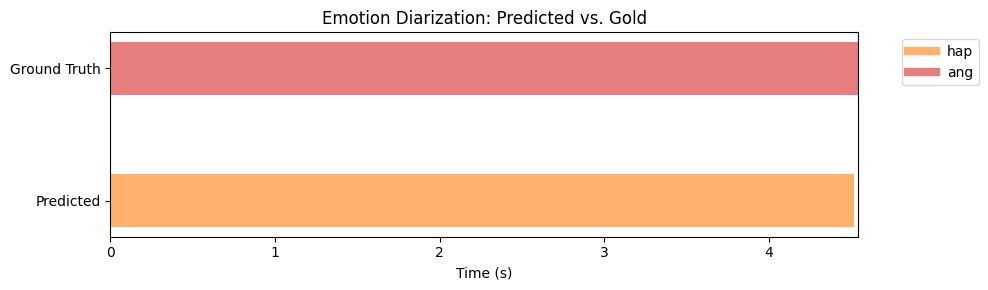

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


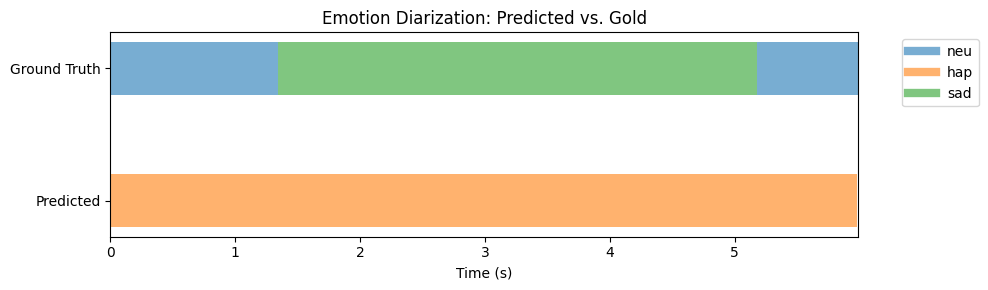

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


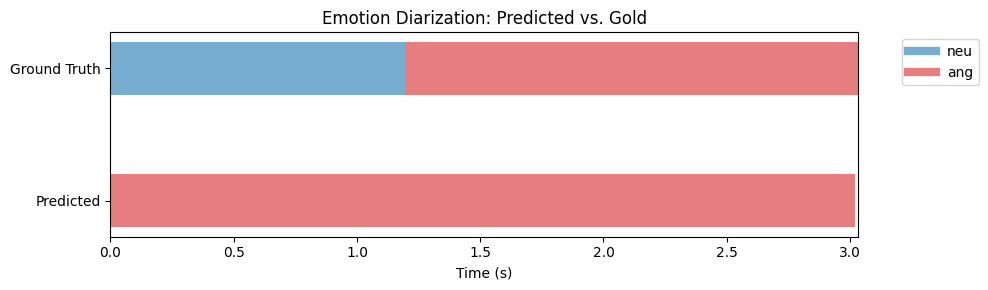

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


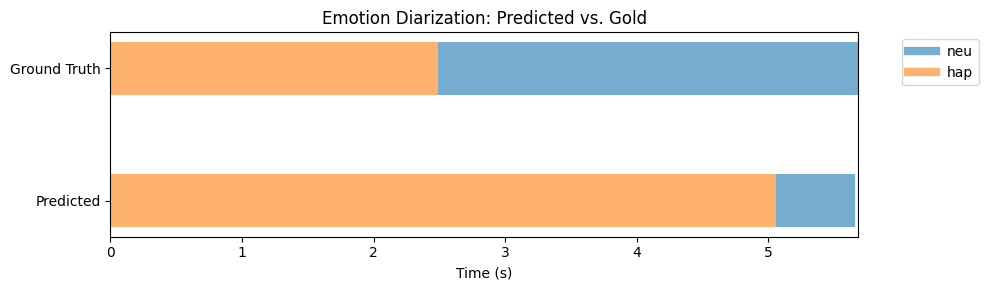

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


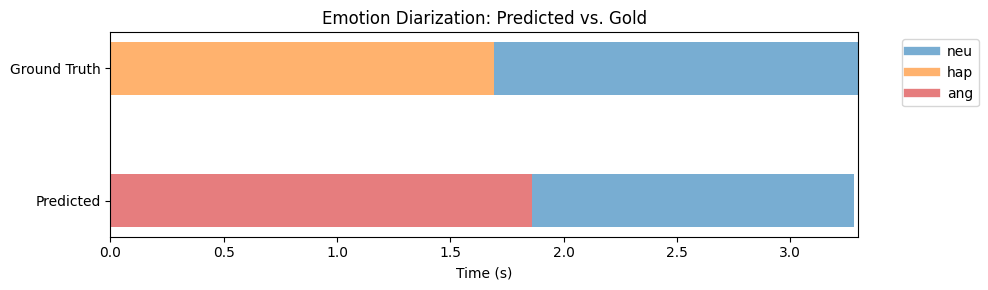

In [ ]:
for i in range(5):
    sample = random.choice(samples)
    pred_emotion = predict_emotion(sample['wav']['array'],sample['wav']['sampling_rate'], model,FE)
    gold = []
    if sample['emotion_start'] > 0:
        gold.append({
            'emo': 'neu',
            'start': 0,
            'end': sample['emotion_start']
        })
    gold.append({
        'emo': id2label[emo_adapt[sample['emotion']]],
        'start': sample['emotion_start'],
        'end': sample['emotion_end']
    })
    if sample['emotion_end'] < sample['duration']:
        gold.append({
            'emo': 'neu',
            'start': sample['emotion_end'],
            'end': sample['duration']
        })
    visualize_segments(sample['duration'], pred_emotion,gold )

In [ ]:
predict_emotion(sample['wav']['array'],sample['wav']['sampling_rate'], model,FE)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[{'emo': 'ang', 'start': 0.0, 'end': 1.86},
 {'emo': 'neu', 'start': 1.86, 'end': 3.2800000000000002}]

In [ ]:
from IPython.display import Audio
Audio(sample['wav']['array'], rate=sample['wav']['sampling_rate'])

In [ ]:
gold

[{'emo': 'hap', 'start': 0.0, 'end': 1.6920000314712524},
 {'emo': 'neu', 'start': 1.6920000314712524, 'end': 3.299999952316284}]